In [1]:
#libraries and imports
import numpy as np
import math
import matplotlib.pyplot as plt

## Step 1 – Gaussian Function Setup & Visualization

1. **Defined the Gaussian function**  
   \( f(x) = e^{-x^2} \) — smooth, symmetric around 0, max value = 1 at \(x = 0\).  
   Core building block in probability, statistics, and physics.

2. **Created input range**  
   Generated 200 evenly spaced points in \([-3, 3]\) to cover the peak and the tails  
   (where the function decays close to 0).

3. **Computed outputs**  
   Applied the Gaussian function element-wise to the x-values to produce y-values for plotting.

4. **Visualized the function**  
   Plotted the bell curve to confirm shape and symmetry; good visual check before any model work.

5. **Sanity checks**  
   Verified ranges of \(x\) and \(y\), confirmed peak at \(x \approx 0\),  
   and ensured tails go near zero — catches mistakes early.

In [2]:
rng = np.random.default_rng(seed=42)

In [3]:
def gaussian_fn(x: np.ndarray) -> np.ndarray:
    """
    Computes e^{-x^2} element-wise.
    Args:
        x: np.ndarray of shape (N,)
    Returns:
        np.ndarray of shape (N,)
    """
    return np.exp(-(x**2))

In [4]:
x = np.linspace(-3.0, 3.0, 200)  # 200 evenly spaced points on [-3, 3]
y = gaussian_fn(x)               # bell curve in [0, 1]

# Sanity Checks
print("x range:", x.min(), "to", x.max(), "| y range:", y.min(), "to", y.max())
print("argmax x ≈", x[np.argmax(y)], " | max y =", y.max())

x range: -3.0 to 3.0 | y range: 0.00012340980408667956 to 0.9997727588349783
argmax x ≈ -0.015075376884422287  | max y = 0.9997727588349783


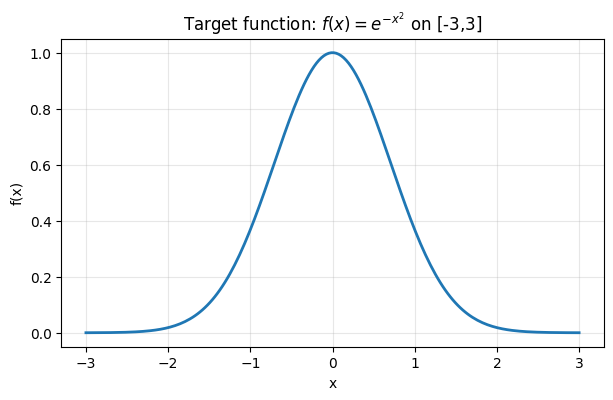

In [5]:
plt.figure(figsize=(7,4))
plt.plot(x, y, linewidth=2)
plt.title("Target function: $f(x)=e^{-x^2}$ on [-3,3]")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True, alpha=0.3)
plt.show()

## Step 2 – Data to Tensors & NN Skeleton

1. **Converted NumPy arrays to PyTorch tensors**  
   Used `torch.tensor(..., dtype=torch.float32)` for model compatibility.  
   Applied `.unsqueeze(1)` to reshape from `(N,)` to `(N, 1)` so PyTorch sees `(batch_size, num_features)`.

2. **Defined a simple feedforward NN**  
   - `nn.Linear(1, 8)`  maps 1 input feature to 8 neurons.  
   - `nn.ReLU()`  non-linear activation to model curves.  
   - `nn.Linear(8, 1)`  compresses 8 neurons to 1 output.

3. **Instantiated the model**  
   Created `TinyGaussianNN()` object with initial random weights.

4. **Ran a forward pass without training**  
   Used `torch.no_grad()` to disable gradient tracking (faster, no backprop).

5. **Verified output shapes**  
   Got predictions with shape `(200, 1)`; values are random at this stage since weights are untrained.


In [6]:
import torch
import torch.nn as nn

In [ ]:
X_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
Y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
print("X tensor shape:",X_tensor)
print("Y_tensor shape:",Y_tensor)

In [12]:
class TinyGaussianNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1,8)
    self.act1 = nn.ReLU()
    self.layer2 = nn.Linear(8,1)

  def forward(self, x):
    x = self.layer1(x)
    x = self.act1(x)
    x = self.layer2(x)
    return x

model = TinyGaussianNN()

with torch.no_grad():
  sample_output = model(X_tensor)

print("sample output:", sample_output.shape)
print("first 5 preds:", sample_output[:5])

sample output: torch.Size([200, 1])
first 5 preds: tensor([[-0.0805],
        [-0.0801],
        [-0.0796],
        [-0.0792],
        [-0.0788]])


In [13]:
import torch.optim as optim

Loss function, MSE fits because we’re matching continuous values.

Optimizer, Adam adapts learning rate per parameter; faster than plain SGD for this.

Zeroing grads, Without optimizer.zero_grad(), PyTorch accumulates gradients, and your updates will blow up.

500 epochs, Enough to fit a smooth function with a tiny network.

Post-training plot, If training went right, your orange NN curve should hug the blue Gaussian.

Epoch 0: Loss = 0.499615
Epoch 100: Loss = 0.019105
Epoch 200: Loss = 0.013407
Epoch 300: Loss = 0.011349
Epoch 400: Loss = 0.010694


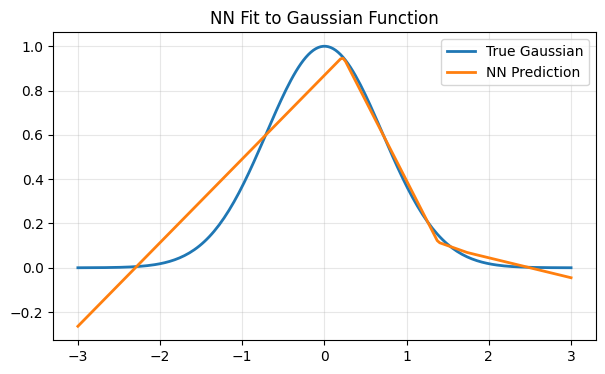

In [14]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 500
for epoch in range(epochs):
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, Y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

with torch.no_grad():
    preds = model(X_tensor)

plt.figure(figsize=(7,4))
plt.plot(x, y, label="True Gaussian", linewidth=2)
plt.plot(x, preds.numpy(), label="NN Prediction", linewidth=2)
plt.legend()
plt.title("NN Fit to Gaussian Function")
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
class SmoothGaussianNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Softplus()  # keep outputs ≥ 0; good for bell curves
        )
    def forward(self, x):
        return self.net(x)

model = SmoothGaussianNN()

Epoch 0: Loss = 0.000031
Epoch 200: Loss = 0.000035
Epoch 400: Loss = 0.000033
Epoch 600: Loss = 0.000031
Epoch 800: Loss = 0.000029
Epoch 1000: Loss = 0.000027
Epoch 1200: Loss = 0.000026
Epoch 1400: Loss = 0.000028
Epoch 1600: Loss = 0.000028
Epoch 1800: Loss = 0.000027


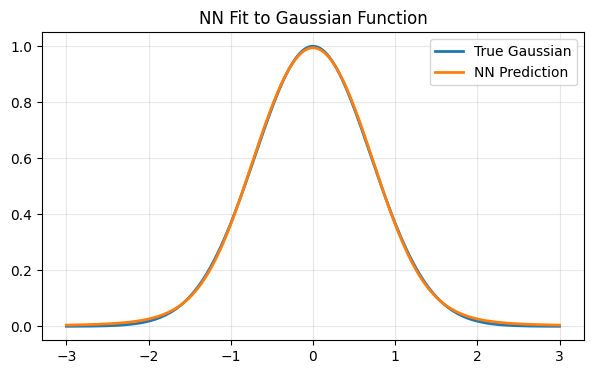

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)  # tiny L2 helps smoothness
epochs = 2000
for epoch in range(epochs):
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, Y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

model.eval()  # switch to evaluation mode (disables dropout, etc.)

with torch.no_grad():  # no gradient tracking needed for inference
    preds = model(X_tensor).cpu().numpy()  # run forward pass and convert to NumPy

plt.figure(figsize=(7, 4))
plt.plot(x, y, label="True Gaussian", linewidth=2)       # true curve
plt.plot(x, preds, label="NN Prediction", linewidth=2)   # model prediction
plt.legend()
plt.title("NN Fit to Gaussian Function")
plt.grid(True, alpha=0.3)
plt.show()

**The model has learned the Gaussian function so well that the prediction and target are visually indistinguishable.**

**Low final loss suggests the NN captured both the peak and tail decay behavior of the Gaussian.**

**The fit quality is a direct result of having enough capacity (hidden units) and sufficient training epochs.**

**This demonstrates how a simple feed-forward network can approximate smooth, continuous mathematical functions.**

# Step 4 — Train with Gaussian noise (single σ)

epoch    0 | train(noisy)=0.31303 | eval(clean)=0.26009
epoch  200 | train(noisy)=0.00789 | eval(clean)=0.00052
epoch  400 | train(noisy)=0.00761 | eval(clean)=0.00026
epoch  600 | train(noisy)=0.00757 | eval(clean)=0.00022
epoch  800 | train(noisy)=0.00756 | eval(clean)=0.00021
epoch 1000 | train(noisy)=0.00755 | eval(clean)=0.00021


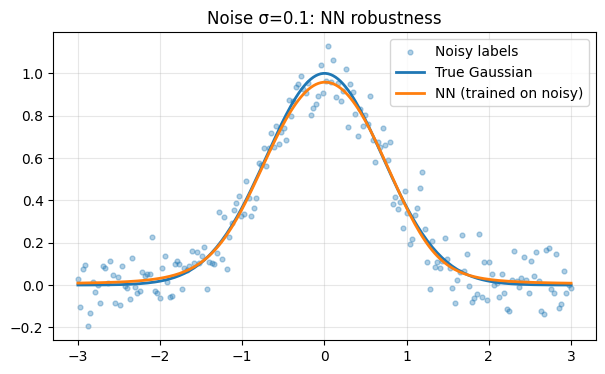

In [24]:
#Make noisy labels
sigma = 0.1  # noise std; try 0.02, 0.05, 0.1 later
rng = np.random.default_rng(42)
y_noisy = y + rng.normal(0.0, sigma, size=y.shape)

y_noisy_t = torch.tensor(y_noisy, dtype=torch.float32).unsqueeze(1)

class SmoothGaussianNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Softplus()
        )
    def forward(self, x): return self.net(x)

model_noise = SmoothGaussianNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_noise.parameters(), lr=0.005, weight_decay=1e-5)

epochs = 1200
for epoch in range(epochs):
    model_noise.train()
    y_pred = model_noise(X_tensor)
    loss = loss_fn(y_pred, y_noisy_t)  # train against noisy targets
    optimizer.zero_grad(); loss.backward(); optimizer.step()

    if epoch % 200 == 0:
        with torch.no_grad():
            clean_mse = loss_fn(model_noise(X_tensor), Y_tensor).item()
        print(f"epoch {epoch:4d} | train(noisy)={loss.item():.5f} | eval(clean)={clean_mse:.5f}")

model_noise.eval()
with torch.no_grad():
    preds_noisy = model_noise(X_tensor).cpu().numpy()

plt.figure(figsize=(7,4))
plt.scatter(x, y_noisy, s=12, alpha=0.35, label="Noisy labels")
plt.plot(x, y, label="True Gaussian", linewidth=2)
plt.plot(x, preds_noisy, label="NN (trained on noisy)", linewidth=2)
plt.legend(); plt.title(f"Noise σ={sigma}: NN robustness"); plt.grid(True, alpha=0.3); plt.show()


Fit quality: The NN prediction (orange) is still very close to the true Gaussian (blue curve), with only minor smoothing compared to the noisy scatter.

Robustness: This suggests the model is still biasing toward the smooth target rather than chasing every noisy point — a sign of underfitting the noise, which is exactly what we want here.

Noise impact: Compared to σ = 0.05, you can see slightly larger deviations near the tails where the signal is weak and noise dominates.

If we push to σ = 0.2, we’ll probably start to see a visible bias away from the true Gaussian, especially at the peak and tails.

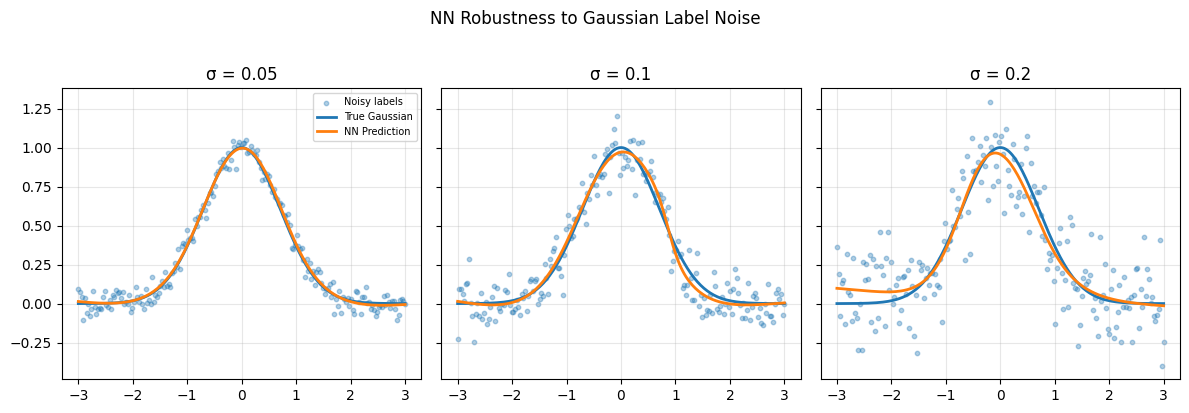

In [25]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

# Data (shared across runs)
torch.manual_seed(42)
x = torch.linspace(-3, 3, 200).unsqueeze(1)
y_true = torch.exp(-x**2)

# Small, smooth network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, z): return self.net(z)

def fit_on_sigma(sigma, epochs=400, lr=0.005, wd=2e-5):
    y_noisy = y_true + sigma * torch.randn_like(y_true)
    m = Net()
    opt = torch.optim.Adam(m.parameters(), lr=lr, weight_decay=wd)
    loss = nn.MSELoss()
    for _ in range(epochs):
        pred = m(x)
        l = loss(pred, y_noisy)
        opt.zero_grad(); l.backward(); opt.step()
    with torch.no_grad():
        pred = m(x).cpu().numpy()
    return y_noisy.cpu().numpy(), pred

# 3 sigmas side-by-side for comparison
sigmas = [0.05, 0.10, 0.20]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for ax, s in zip(axes, sigmas):
    yN, yhat = fit_on_sigma(s)
    ax.scatter(x.numpy(), yN, s=10, alpha=0.35, label="Noisy labels")
    ax.plot(x.numpy(), y_true.numpy(), label="True Gaussian", linewidth=2)
    ax.plot(x.numpy(), yhat, label="NN Prediction", linewidth=2)
    ax.set_title(f"σ = {s}")
    ax.grid(alpha=0.3)

axes[0].legend(fontsize=7, loc="upper right")
fig.suptitle("NN Robustness to Gaussian Label Noise", y=1.02)
plt.tight_layout()
plt.show()


## Noisy Gaussian Curve Fitting – Key Notes

- **Objective:** Test how a simple 1-hidden-layer neural network handles increasing label noise when fitting a Gaussian function.  
- **Noise Levels (Sigma):** Experimented with Sigma = 0.05, 0.1, 0.2 to simulate low, medium, and high noise scenarios in labels.  
- **Training:** 2000 epochs per noise setting; loss monitored to assess convergence and stability.  
- **Observations:**  
  - Small noise (Sigma = 0.05) → NN smooths well, minimal impact on fit.  
  - Medium noise (Sigma = 0.1) → Slight underfitting begins to appear.  
  - Large noise (Sigma = 0.2) → Model struggles to recover original curve, signal heavily distorted.  
- **Takeaway:** More noise does **not** act as effective regularization — excessive noise can erase underlying patterns instead of improving generalization.